In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import roc_auc_score, average_precision_score
from matplotlib import pyplot as plt
import seaborn as sns
import torch

EXPERIMENT_DIR = Path("/gpfs/Labs/Uzun/DATA/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/experiments/mESC_two_hop_no_hvg_small/chr19/model_training_002/")
PROJECT_DIR = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER"
GROUND_TRUTH_DIR = Path(PROJECT_DIR, "data/ground_truth_files")
OTHER_METHOD_DIR = Path("/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.GRN_BENCHMARKING.MOELLER/testing_bear_grn/INFERRED.GRNS")

sample_name_list = ["E7.5_rep1"]

## Testing Gradient Attribution

### Functions

In [ ]:
def load_vocab(selected_experiment_dir):
    id2name = torch.load(selected_experiment_dir / "tf_tg_vocab_id2name.pt", map_location="cpu")
    tf_names = list(id2name["tf_id2name"])
    tg_names = list(id2name["tg_id2name"])

    return tf_names, tg_names

def load_ground_truth(ground_truth_file):
    if ground_truth_file.suffix == ".csv":
        sep = ","
    elif ground_truth_file.suffix == ".tsv":
        sep="\t"
        
    ground_truth_df = pd.read_csv(ground_truth_file, sep=sep, on_bad_lines="skip", engine="python")
    
    if "chip" in ground_truth_file.name and "atlas" in ground_truth_file.name:
        ground_truth_df = ground_truth_df[["source_id", "target_id"]]

    ground_truth_df = ground_truth_df.rename(columns={ground_truth_df.columns[0]: "Source", ground_truth_df.columns[1]: "Target"})
    ground_truth_df["Source"] = ground_truth_df["Source"].astype(str).str.upper()
    ground_truth_df["Target"] = ground_truth_df["Target"].astype(str).str.upper()
        
    return ground_truth_df

def prep_gt_edges(gt_df: pd.DataFrame) -> pd.DataFrame:
    gt = gt_df[["Source", "Target"]].dropna().copy()
    gt["Source"] = gt["Source"].astype(str).str.upper()
    gt["Target"] = gt["Target"].astype(str).str.upper()
    gt = gt.drop_duplicates()
    gt["_in_gt"] = 1
    return gt

def eval_method_vs_gt(method_df: pd.DataFrame, gt_edges: pd.DataFrame, top_fracs=(0.001, 0.005, 0.01, 0.05)):
    if method_df is None or len(method_df) == 0:
        # return NaNs but keep consistent columns
        out = {
            "auroc": np.nan, "auprc": np.nan, "pos_rate": np.nan, "lift_auprc": np.nan
        }
        for frac in top_fracs:
            out[f"precision@{frac*100:.2f}%"] = np.nan
            out[f"lift@{frac*100:.2f}%"] = np.nan
        return out

    # Merge GRN with ground truth to label edges
    d = method_df.merge(gt_edges, on=["Source", "Target"], how="left")
    y = d["_in_gt"].fillna(0).astype(int).to_numpy()
    s = d["Score"].to_numpy()

    # Calculate AUROC and AUPRC scores
    auroc = roc_auc_score(y, s) if np.unique(y).size == 2 else np.nan
    auprc = average_precision_score(y, s) if y.sum() > 0 else np.nan
    pos_rate = y.mean()

    # Pre-sort once for precision@K
    order = np.argsort(s)[::-1]
    y_sorted = y[order]
    tp = np.cumsum(y_sorted)
    k = np.arange(1, len(y_sorted) + 1)
    prec = tp / k

    # Calculate precision@K and lift@K for each K
    prec_at = {}
    for frac in top_fracs:
        K = int(frac * len(y_sorted))
        if K < 1:
            K = 1
        if K > len(prec):
            K = len(prec)
        prec_at[f"precision@{frac*100:.2f}%"] = float(prec[K-1]) if len(prec) else np.nan
        prec_at[f"lift@{frac*100:.2f}%"] = float(prec[K-1] / pos_rate) if (len(prec) and pos_rate > 0) else np.nan

    return {
        "auroc": float(auroc) if auroc == auroc else np.nan,
        "auprc": float(auprc) if auprc == auprc else np.nan,
        "pos_rate": float(pos_rate) if pos_rate == pos_rate else np.nan,
        "lift_auprc": float(auprc / pos_rate) if (pos_rate > 0 and auprc == auprc) else np.nan,
        **prec_at
    }

def restrict_to_gt_universe(method_df: pd.DataFrame, gt_edges: pd.DataFrame) -> pd.DataFrame:
    gt_tfs = set(gt_edges["Source"])
    gt_tgs = set(gt_edges["Target"])
    return method_df[method_df["Source"].isin(gt_tfs) & method_df["Target"].isin(gt_tgs)].copy()

def load_grad_df_with_two_scores(selected_experiment_dir, tf_names, tg_names):
    grad = np.load(selected_experiment_dir / "tf_tg_grad_attribution.npy").astype(np.float32)
    assert grad.shape == (len(tf_names), len(tg_names))

    grad = np.nan_to_num(grad, nan=0.0)
    grad_abs = np.abs(grad)

    score_pooled = np.log1p(grad_abs)

    # Calculate per-TF robust z-score
    median_val = np.median(grad_abs, axis=1, keepdims=True)
    mad = np.median(np.abs(grad_abs - median_val), axis=1, keepdims=True) + 1e-6
    score_per_tf = (grad_abs - median_val) / mad

    T, G = grad_abs.shape
    tf_idx, tg_idx = np.meshgrid(np.arange(T), np.arange(G), indexing="ij")

    df = pd.DataFrame({
        "Source": np.asarray(tf_names, dtype=object)[tf_idx.ravel()],
        "Target": np.asarray(tg_names, dtype=object)[tg_idx.ravel()],
        "Score_pooled": score_pooled.ravel(),
        "Score_per_tf": score_per_tf.ravel(),
    })
    df["Source"] = df["Source"].astype(str).str.upper()
    df["Target"] = df["Target"].astype(str).str.upper()
    return df

def load_tf_knockout_scores_with_two_scores(
    selected_experiment_dir,
    tf_names,
    tg_names,
    positive_only: bool = True,
    eps: float = 1e-6,
):
    """
    Loads TF-knockout effects and returns a long-form DF with two scores:

      - Score_pooled: log1p(effect_used)  (global magnitude-compressed score)
      - Score_per_tf: robust per-TF score = (effect_used - median_tf) / MAD_tf

    Where effect_used is either:
      - clip(effect, 0, inf) if positive_only=True
      - effect (signed) if positive_only=False

    Notes:
      - Unobserved entries (counts==0) are set to NaN and dropped in the output.
      - If positive_only=True, effects at 0 are valid and retained.
    """
    effect = np.load(selected_experiment_dir / "tf_tg_fullmodel_knockout.npy").astype(np.float32)         # [T, G]
    counts = np.load(selected_experiment_dir / "tf_tg_fullmodel_knockout_count.npy").astype(np.int32)    # [T, G]
    assert effect.shape == (len(tf_names), len(tg_names))
    assert counts.shape == effect.shape

    # Mark unobserved as NaN
    mask_observed = counts > 0
    effect = effect.copy()
    effect[~mask_observed] = np.nan

    # Choose effect representation
    if positive_only:
        effect_used = np.clip(effect, 0, None)  # keep NaNs
    else:
        effect_used = effect  # signed, keep NaNs

    # --- pooled score ---
    # If signed, use abs for pooled magnitude (keeps "strength" notion comparable to gradient pooled)
    pooled_base = effect_used if positive_only else np.abs(effect_used)
    score_pooled = np.log1p(pooled_base)

    # --- per-TF robust score ---
    med = np.nanmedian(effect_used, axis=1, keepdims=True)
    mad = np.nanmedian(np.abs(effect_used - med), axis=1, keepdims=True) + eps
    score_per_tf = (effect_used - med) / mad

    # --- build long-form DF ---
    T, G = effect_used.shape
    tf_idx, tg_idx = np.meshgrid(np.arange(T), np.arange(G), indexing="ij")

    df = pd.DataFrame({
        "Source": np.asarray(tf_names, dtype=object)[tf_idx.ravel()],
        "Target": np.asarray(tg_names, dtype=object)[tg_idx.ravel()],
        "Score_pooled": score_pooled.ravel(),
        "Score_per_tf": score_per_tf.ravel(),
        "counts": counts.ravel(),
    })

    # Drop unobserved (Score_pooled will be NaN there)
    df = df.dropna(subset=["Score_pooled"]).reset_index(drop=True)

    df["Source"] = df["Source"].astype(str).str.upper()
    df["Target"] = df["Target"].astype(str).str.upper()
    return df


def load_and_standardize_method(name: str, info: dict) -> pd.DataFrame:
    """
    Load a GRN CSV and rename tf_col/target_col/score_col -> Source/Target/Score.
    Extra columns are preserved.
    """
    if info["path"].suffix == ".tsv":
        sep = "\t"
    elif info["path"].suffix == ".csv":
        sep = ","
    
    df = pd.read_csv(info["path"], sep=sep, header=0, index_col=None)

    tf_col     = info["tf_col"]
    target_col = info["target_col"]
    score_col  = info["score_col"]

    rename_map = {
        tf_col: "Source",
        target_col: "Target",
        score_col: "Score",
    }

    missing = [c for c in rename_map if c not in df.columns]
    if missing:
        raise ValueError(f"[{name}] Missing expected columns: {missing}. Got: {list(df.columns)}")

    df = df.rename(columns=rename_map)

    df = df[["Source", "Target", "Score"]]
    df["Source"] = df["Source"].astype(str).str.upper()
    df["Target"] = df["Target"].astype(str).str.upper()

    return df

def per_tf_metrics(
    method_df: pd.DataFrame, 
    gt_edges: pd.DataFrame, 
    top_fracs=(0.001, 0.005, 0.01, 0.05), 
    min_edges=10, min_pos=1
    ) -> pd.DataFrame:
    """
    Returns a per-TF dataframe with:
      TF, AUROC, n_pos, n_neg, pos_rate, Precision@K, Lift@K (for each K)
    Assumes method_df has Source/Target/Score and is already restricted to GT universe (recommended).
    """
    # Label edges
    d = method_df.merge(gt_edges, on=["Source", "Target"], how="left")
    d["_in_gt"] = d["_in_gt"].fillna(0).astype(int)

    rows = []
    for tf, g in d.groupby("Source", sort=False):
        y = g["_in_gt"].to_numpy()
        s = g["Score"].to_numpy()
        n = len(y)
        n_pos = int(y.sum())
        n_neg = int(n - n_pos)
        pos_rate = (n_pos / n) if n > 0 else np.nan
        
        # basic filters to avoid degenerate metrics
        if n < min_edges:
            continue
        if n_pos < min_pos or n_neg == 0:
            continue

        # AUROC defined only if both classes present
        auc = roc_auc_score(y, s) if (n_pos > 0 and n_neg > 0) else np.nan
        auprc = average_precision_score(y, s) if (n_pos > 0 and n_neg > 0) else np.nan
        
        # Pre-sort once for precision@K
        order = np.argsort(s)[::-1]
        y_sorted = y[order]
        tp = np.cumsum(y_sorted)

        row = {
            "tf": tf,
            "n_edges": n,
            "n_pos": n_pos,
            "n_neg": n_neg,
            "pos_rate": pos_rate,
            "auroc": float(auc) if auc == auc else np.nan,
            "auprc": float(auprc) if auprc == auprc else np.nan,
        }

        for frac in top_fracs:
            K = max(1, int(frac * n))
            K = min(K, n)
            prec_k = float(tp[K-1] / K) if n > 0 else np.nan
            row[f"precision@{frac*100:.2f}%"] = prec_k
            row[f"lift@{frac*100:.2f}%"] = (prec_k / pos_rate) if (pos_rate and pos_rate > 0) else np.nan

        rows.append(row)

    return pd.DataFrame(rows)

### Load Ground Truth Datsets

In [35]:
# mESC ground truth files
ground_truth_file_dict = {
    "ChIP-Atlas": GROUND_TRUTH_DIR / "chip_atlas_tf_peak_tg_dist.csv",
    "RN111": GROUND_TRUTH_DIR / "RN111.tsv",
    "RN112": GROUND_TRUTH_DIR / "RN112.tsv",
    "RN114": GROUND_TRUTH_DIR / "RN114.tsv",
    "RN116": GROUND_TRUTH_DIR / "RN116.tsv",
}

# Loop through each ground truth dataset and load each file
ground_truth_df_dict = {}
for i, (gt_name, ground_truth_file) in enumerate(ground_truth_file_dict.items(), start=1):
    print(f"Loading {gt_name} ({i}/{len(ground_truth_file_dict)})")

    # --- Ground truth & sets ---
    ground_truth_df = load_ground_truth(ground_truth_file)
    
    ground_truth_df_dict[gt_name] = ground_truth_df
    print(f"  - TFs: {ground_truth_df['Source'].nunique():,}, TGs: {ground_truth_df['Target'].nunique():,}, Edges: {len(ground_truth_df):,}")

ground_truth_edges_dict = {gt: prep_gt_edges(df) for gt, df in ground_truth_df_dict.items()}

Loading ChIP-Atlas (1/5)
  - TFs: 131, TGs: 24,821, Edges: 7,734,466
Loading RN111 (2/5)
  - TFs: 247, TGs: 25,692, Edges: 972,636
Loading RN112 (3/5)
  - TFs: 55, TGs: 16,522, Edges: 104,201
Loading RN114 (4/5)
  - TFs: 47, TGs: 21,240, Edges: 107,980
Loading RN116 (5/5)
  - TFs: 21, TGs: 4,542, Edges: 8,170


### Load Other Method GRNs

In [72]:
sample_method_dict = {}
for sample_name in sample_name_list:
    print(f"\nProcessing sample: {sample_name}")
    cell_oracle_path  = OTHER_METHOD_DIR / f"{sample_name}/CellOracle/filtered_L2_{sample_name}_out_E7.5_rep1_final_GRN.csv"
    directnet_path    = OTHER_METHOD_DIR / f"{sample_name}/DIRECTNET/{sample_name}_all_cells_Network_links.csv"
    figr_path         = OTHER_METHOD_DIR / f"{sample_name}/FigR/{sample_name}_all_cells_filtered_network.csv"
    granie_path       = OTHER_METHOD_DIR / f"{sample_name}/GRaNIE/GRN_connections_filtered_sorted_sc{sample_name}_all_cells_selected_uniq.csv"
    linger_path       = OTHER_METHOD_DIR / f"{sample_name}/LINGER/filtered_L2_{sample_name}.csv"
    pando_path        = OTHER_METHOD_DIR / f"{sample_name}/Pando/{sample_name}_all_cells_raw_network.csv"
    scenic_plus_path  = OTHER_METHOD_DIR / f"{sample_name}/SCENIC+/scenic_plus_inferred_grn_mESC_filtered_L2_{sample_name}.tsv"
    tripod_path       = OTHER_METHOD_DIR / f"{sample_name}/TRIPOD/gene_TF_highest_abs_coef.csv"
    method_info = {
        "CellOracle": {"path": cell_oracle_path, "tf_col": "source",    "target_col": "target",    "score_col": "coef_mean"},
        "SCENIC+":    {"path": scenic_plus_path, "tf_col": "Source",    "target_col": "Target",    "score_col": "Score"},
        "Pando":      {"path": pando_path,       "tf_col": "tf",        "target_col": "target",    "score_col": "estimate"},
        "LINGER":     {"path": linger_path,      "tf_col": "Source",    "target_col": "Target",    "score_col": "Score"},
        "FigR":       {"path": figr_path,        "tf_col": "Motif",     "target_col": "DORC",      "score_col": "Score"},
        "TRIPOD":     {"path": tripod_path,      "tf_col": "TF",        "target_col": "gene",      "score_col": "abs_coef"},
        "GRaNIE":     {"path": granie_path,      "tf_col": "TF.name",   "target_col": "gene.name", "score_col": "TF_gene.r"},
    }
            
    standardized_method_dict = {}

    for method_name, info in method_info.items():
        print(f"  - Loading {method_name}")
        df_std = load_and_standardize_method(method_name, info)
        standardized_method_dict[method_name] = df_std
    
    tf_names, tg_names = load_vocab(EXPERIMENT_DIR)
    print("  - Loading Gradient Attribution")
    grad_attrib_df = load_grad_df_with_two_scores(
        selected_experiment_dir=EXPERIMENT_DIR,
        tf_names=tf_names,
        tg_names=tg_names,
    )

    grad_df = grad_attrib_df.copy()
    grad_df["Score"] = grad_df["Score_pooled"]
    grad_df = grad_df[["Source", "Target", "Score"]]

    standardized_method_dict["Gradient Attribution"] = grad_df
    
    print("  - Loading TF Knockout")
    tf_ko_df = load_tf_knockout_scores_with_two_scores(
        selected_experiment_dir=EXPERIMENT_DIR,
        tf_names=tf_names,
        tg_names=tg_names,
        positive_only=True,
        eps=1e-6,
    )
    tf_ko_df["Score"] = tf_ko_df["Score_pooled"]
    tf_ko_df = tf_ko_df[["Source", "Target", "Score"]]

    standardized_method_dict["TF Knockout"] = tf_ko_df
    
    sample_method_dict[sample_name] = standardized_method_dict 



Processing sample: E7.5_rep1
  - Loading CellOracle
  - Loading SCENIC+
  - Loading Pando
  - Loading LINGER
  - Loading FigR
  - Loading TRIPOD
  - Loading GRaNIE
  - Loading Gradient Attribution
  - Loading TF Knockout

Processing sample: E7.5_rep2
  - Loading CellOracle
  - Loading SCENIC+
  - Loading Pando
  - Loading LINGER
  - Loading FigR
  - Loading TRIPOD
  - Loading GRaNIE
  - Loading Gradient Attribution
  - Loading TF Knockout

Processing sample: E8.5_rep1
  - Loading CellOracle
  - Loading SCENIC+
  - Loading Pando
  - Loading LINGER
  - Loading FigR
  - Loading TRIPOD
  - Loading GRaNIE
  - Loading Gradient Attribution
  - Loading TF Knockout

Processing sample: E8.5_rep2
  - Loading CellOracle
  - Loading SCENIC+
  - Loading Pando
  - Loading LINGER
  - Loading FigR
  - Loading TRIPOD
  - Loading GRaNIE
  - Loading Gradient Attribution
  - Loading TF Knockout


### Calculate Evaluation Metrics

In [73]:
# Pool scores across samples first (mean per edge per method)
print("Pooling methods across samples")
pooled_method_dict = {}
if sample_method_dict:
    first_sample = next(iter(sample_method_dict))
    for method_name in sample_method_dict[first_sample]:
        dfs = []
        for sample_name, method_dict in sample_method_dict.items():
            if method_name in method_dict:
                dfs.append(method_dict[method_name])
        if dfs:
            pooled_df = (
                pd.concat(dfs, ignore_index=True)
                .groupby(["Source", "Target"], as_index=False)["Score"]
                .mean()
            )
            pooled_method_dict[method_name] = pooled_df

# Pooled AUROC/AUPRC
print("\nEvaluating pooled methods across samples")
all_results = []
for method_name, method_df in pooled_method_dict.items():
    print(f"  - Evaluating {method_name}")
    for gt_name, gt_edges in ground_truth_edges_dict.items():
        d_eval = restrict_to_gt_universe(method_df, gt_edges)
        if len(d_eval) == 0:
            print(f"  - {gt_name}: no overlap, skipping")
            continue
        metrics = eval_method_vs_gt(d_eval, gt_edges)
        all_results.append({"method": method_name, "gt": gt_name, **metrics})

results_df = pd.DataFrame(all_results)
results_df.groupby("method")["auroc"].mean().sort_values(ascending=False)

top_fracs = (0.001, 0.005, 0.01, 0.05)
per_tf_all = []
per_tf_summary = []

print("\nPer-TF evaluation of pooled methods across samples")
for method_name, method_df in pooled_method_dict.items():
    print(f"  - Per-TF evaluating {method_name}")
    for gt_name, gt_edges in ground_truth_edges_dict.items():
        d_eval = restrict_to_gt_universe(method_df, gt_edges)
        if len(d_eval) == 0:
            continue

        tf_df = per_tf_metrics(d_eval, gt_edges, top_fracs=top_fracs)
        tf_df.insert(0, "gt", gt_name)
        tf_df.insert(0, "method", method_name)
        per_tf_all.append(tf_df)

        defined = tf_df.dropna(subset=["auroc"])
        frac_defined = len(defined) / len(tf_df) if len(tf_df) else np.nan

        row = {
            "method": method_name,
            "gt": gt_name,
            "n_tf_total": int(len(tf_df)),
            "n_tf_auroc_defined": int(len(defined)),
            "frac_tf_auroc_defined": float(frac_defined) if frac_defined == frac_defined else np.nan,
            "mean_per_tf_auroc": float(defined["auroc"].mean()) if len(defined) else np.nan,
            "median_per_tf_auroc": float(defined["auroc"].median()) if len(defined) else np.nan,
        }

        for frac in top_fracs:
            lift_col = f"lift@{frac*100:.2f}%"
            lift_vals = tf_df.replace([np.inf, -np.inf], np.nan).dropna(subset=[lift_col])[lift_col]
            row[f"median_{lift_col}"] = float(lift_vals.median()) if len(lift_vals) else np.nan
            row[f"mean_{lift_col}"] = float(lift_vals.mean()) if len(lift_vals) else np.nan

        per_tf_summary.append(row)

per_tf_all_df = pd.concat(per_tf_all, ignore_index=True) if per_tf_all else pd.DataFrame()
per_tf_summary_df = pd.DataFrame(per_tf_summary)

per_tf_summary_df.head()

Evaluating CellOracle
Evaluating SCENIC+
Evaluating Pando
Evaluating LINGER
Evaluating FigR
Evaluating TRIPOD
Evaluating GRaNIE
Evaluating Gradient Attribution
Evaluating TF Knockout
Per-TF evaluating CellOracle
Per-TF evaluating SCENIC+
Per-TF evaluating Pando
Per-TF evaluating LINGER
Per-TF evaluating FigR
Per-TF evaluating TRIPOD
Per-TF evaluating GRaNIE
Per-TF evaluating Gradient Attribution
Per-TF evaluating TF Knockout


,method,gt,n_tf_total,n_tf_auroc_defined,frac_tf_auroc_defined,mean_per_tf_auroc,median_per_tf_auroc,median_lift@0.10%,mean_lift@0.10%,median_lift@0.50%,mean_lift@0.50%,median_lift@1.00%,mean_lift@1.00%,median_lift@5.00%,mean_lift@5.00%
0,CellOracle,ChIP-Atlas,54,54,1.0,0.514011,0.504936,0.0,1.294583,0.910972,1.815060,0.984278,1.655047,1.178222,1.401288
1,CellOracle,RN111,56,56,1.0,0.506028,0.503382,0.0,0.635575,0.752975,0.845359,0.845727,0.981721,0.928687,0.950971
2,CellOracle,RN112,25,25,1.0,0.499190,0.498523,0.0,3.367419,1.672081,2.117562,1.573911,2.411598,1.725417,2.101798
3,CellOracle,RN114,24,24,1.0,0.517858,0.514612,0.0,1.117819,0.899453,1.493359,1.019222,1.871959,1.231166,1.281100
4,CellOracle,RN116,10,10,1.0,0.495851,0.489155,0.0,0.230568,0.000000,0.826971,0.606742,0.707768,1.320759,1.377442


In [74]:
merged = results_df.merge(per_tf_summary_df, on=["method", "gt"], how="left")
merged.to_csv("dev/notebooks/all_methods_auroc_scores_df.csv", index=False)
merged.head()


,method,gt,auroc,auprc,pos_rate,lift_auprc,precision@0.10%,lift@0.10%,precision@0.50%,lift@0.50%,...,mean_per_tf_auroc,median_per_tf_auroc,median_lift@0.10%,mean_lift@0.10%,median_lift@0.50%,mean_lift@0.50%,median_lift@1.00%,mean_lift@1.00%,median_lift@5.00%,mean_lift@5.00%
0,CellOracle,ChIP-Atlas,0.518055,0.447353,0.433691,1.031501,0.445378,1.026948,0.449833,1.037219,...,0.514011,0.504936,0.0,1.294583,0.910972,1.815060,0.984278,1.655047,1.178222,1.401288
1,CellOracle,RN111,0.495302,0.430368,0.433885,0.991893,0.481865,1.110582,0.434333,1.001032,...,0.506028,0.503382,0.0,0.635575,0.752975,0.845359,0.845727,0.981721,0.928687,0.950971
2,CellOracle,RN112,0.472838,0.087788,0.078774,1.114431,0.351852,4.466605,0.186813,2.371511,...,0.499190,0.498523,0.0,3.367419,1.672081,2.117562,1.573911,2.411598,1.725417,2.101798
3,CellOracle,RN114,0.538966,0.233239,0.219496,1.062614,0.170732,0.777836,0.191283,0.871467,...,0.517858,0.514612,0.0,1.117819,0.899453,1.493359,1.019222,1.871959,1.231166,1.281100
4,CellOracle,RN116,0.506064,0.081844,0.074960,1.091831,0.142857,1.905775,0.111111,1.482270,...,0.495851,0.489155,0.0,0.230568,0.000000,0.826971,0.606742,0.707768,1.320759,1.377442


In [75]:
(
    merged.groupby("method")["mean_per_tf_auroc"]
    .mean()
    .sort_values(ascending=False)
)


method
Gradient Attribution    0.568720
TRIPOD                  0.540111
GRaNIE                  0.532401
TF Knockout             0.530036
Pando                   0.529596
SCENIC+                 0.520390
FigR                    0.517663
LINGER                  0.516218
CellOracle              0.506587
Name: mean_per_tf_auroc, dtype: float64

In [76]:
(
    merged.groupby("method")["median_lift@0.10%"]
    .mean()
    .sort_values(ascending=False)
)


method
TRIPOD                  1.159584
Gradient Attribution    1.157042
TF Knockout             1.060673
LINGER                  0.754277
FigR                    0.594980
GRaNIE                  0.563171
Pando                   0.117941
CellOracle              0.000000
SCENIC+                 0.000000
Name: median_lift@0.10%, dtype: float64

In [77]:
def plot_pooled_auroc_boxplot(df, per_tf=False):
    # 1. Order methods by mean AUROC (highest → lowest)
    method_order = (
        df.groupby("method")["auroc"]
        .mean()
        .sort_values(ascending=False)
        .index
    )

    # 2. Prepare data in that order
    data = [df.loc[df["method"] == m, "auroc"].values for m in method_order]

    feature_list = [
        "Gradient Attribution",
    ]
    my_color = "#4195df"
    other_color = "#747474"

    fig, ax = plt.subplots(figsize=(10, 6))

    # Baseline random line
    ax.axhline(y=0.5, color="#2D2D2D", linestyle='--', linewidth=1)

    # --- Boxplot (existing styling) ---
    bp = ax.boxplot(
        data,
        tick_labels=method_order,
        patch_artist=True,
        showfliers=False
    )

    # Color boxes: light blue for your methods, grey for others
    for box, method in zip(bp["boxes"], method_order):
        if method in feature_list:
            box.set_facecolor(my_color)
        else:
            box.set_facecolor(other_color)

    # Medians in black
    for median in bp["medians"]:
        median.set_color("black")

    # --- NEW: overlay jittered points for each method ---
    for i, method in enumerate(method_order, start=1):
        y = df.loc[df["method"] == method, "auroc"].values
        if len(y) == 0:
            continue

        # Small horizontal jitter around the box center (position i)
        x = np.random.normal(loc=i, scale=0.06, size=len(y))

        # Match point color to box color
        point_color = my_color if method in feature_list else other_color

        ax.scatter(
            x, y,
            color=point_color,
            alpha=0.7,
            s=18,
            edgecolor="k",
            linewidth=0.3,
            zorder=3,
        )
        
        mean_val = y.mean()
        ax.scatter(
            i, mean_val,
            color="white",
            edgecolor="k",
            s=30,
            zorder=4,
        )

    ax.set_xlabel("Method")
    ax.set_ylabel("AUROC across ground truths")
    if per_tf == True:
        ax.set_title("per-TF AUROC Scores per method")
        ax.set_ylim((0.0, 1.0))
    else:
        ax.set_title("AUROC Scores per method")
        ax.set_ylim((0.0, 1.0))

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    plt.tight_layout()
    
    return fig

def plot_all_results_auroc_boxplot(df, per_tf=False):
    # 1. Order methods by mean AUROC (highest → lowest)
    method_order = (
        df.groupby("name")["auroc"]
        .mean()
        .sort_values(ascending=False)
        .index
    )

    # 2. Prepare data in that order
    data = [df.loc[df["name"] == m, "auroc"].values for m in method_order]

    feature_list = [
        "Gradient Attribution",
        "TF Knockout",
        "TF-TG Embedding Similarity",
        "Shortcut Attention"
    ]
    my_color = "#4195df"
    other_color = "#747474"

    fig, ax = plt.subplots(figsize=(10, 6))

    # Baseline random line
    ax.axhline(y=0.5, color="#2D2D2D", linestyle='--', linewidth=1)

    # --- Boxplot (existing styling) ---
    bp = ax.boxplot(
        data,
        tick_labels=method_order,
        patch_artist=True,
        showfliers=False
    )

    # Color boxes: light blue for your methods, grey for others
    for box, method in zip(bp["boxes"], method_order):
        if method in feature_list:
            box.set_facecolor(my_color)
        else:
            box.set_facecolor(other_color)

    # Medians in black
    for median in bp["medians"]:
        median.set_color("black")

    # --- NEW: overlay jittered points for each method ---
    for i, method in enumerate(method_order, start=1):
        y = df.loc[df["name"] == method, "auroc"].values
        if len(y) == 0:
            continue

        # Small horizontal jitter around the box center (position i)
        x = np.random.normal(loc=i, scale=0.06, size=len(y))

        # Match point color to box color
        point_color = my_color if method in feature_list else other_color

        ax.scatter(
            x, y,
            color=point_color,
            alpha=0.7,
            s=18,
            edgecolor="k",
            linewidth=0.3,
            zorder=3,
        )
        
        mean_val = y.mean()
        ax.scatter(
            i, mean_val,
            color="white",
            edgecolor="k",
            s=30,
            zorder=4,
        )

    ax.set_xlabel("Method")
    ax.set_ylabel("AUROC across ground truths")
    if per_tf == True:
        ax.set_title("per-TF AUROC Scores per method")
        ax.set_ylim((0.2, 0.8))
    else:
        ax.set_title("AUROC Scores per method")
        ax.set_ylim((0.2, 0.8))

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    plt.tight_layout()
    
    return fig

In [87]:
auroc_testing_per_tf_df = pd.read_csv(EXPERIMENT_DIR / "per_tf_auroc_auprc_detailed.csv")
auroc_testing_per_tf_df = auroc_testing_per_tf_df[["method", "gt_name", "tf", "auroc", "auprc"]].rename(columns={"gt_name": "gt"})
auroc_testing_per_tf_df.head()

,method,gt,tf,auroc,auprc
0,CellOracle,ChIP-Atlas,CREB1,0.560112,0.542093
1,CellOracle,ChIP-Atlas,CTCF,0.535372,0.603430
2,CellOracle,ChIP-Atlas,EBF1,0.502612,0.497458
3,CellOracle,ChIP-Atlas,EOMES,0.426318,0.487132
4,CellOracle,ChIP-Atlas,EP300,0.513520,0.526320


In [89]:
df = per_tf_all_df.copy()
merged = df.merge(
    auroc_testing_per_tf_df,
    on=["method", "gt", "tf"],
    suffixes=("_dev", "_tf_testing"),
    how="inner"
)
df = merged[["method", "gt", "tf", "auroc_dev", "auroc_tf_testing"]]
df["difference"] = df["auroc_dev"] - df["auroc_tf_testing"]
df.head()

/tmp/ipykernel_3917534/2312182250.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["difference"] = df["auroc_dev"] - df["auroc_tf_testing"]


,method,gt,tf,auroc_dev,auroc_tf_testing,difference
0,CellOracle,ChIP-Atlas,CREB1,0.494514,0.560112,-0.065598
1,CellOracle,ChIP-Atlas,CTCF,0.525392,0.535372,-0.009979
2,CellOracle,ChIP-Atlas,EBF1,0.486240,0.502612,-0.016372
3,CellOracle,ChIP-Atlas,EOMES,0.463703,0.426318,0.037385
4,CellOracle,ChIP-Atlas,EP300,0.515791,0.513520,0.002271


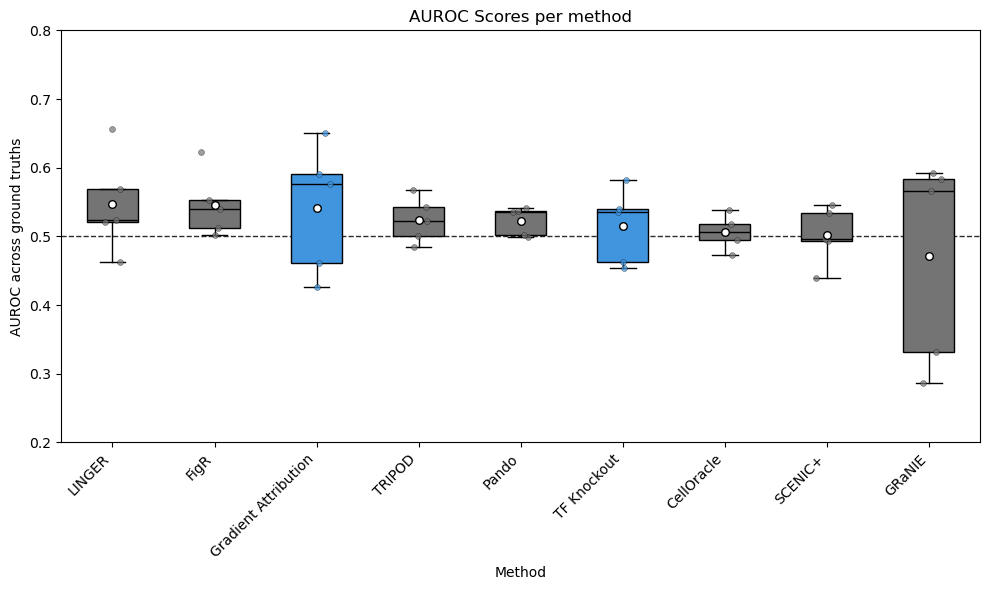

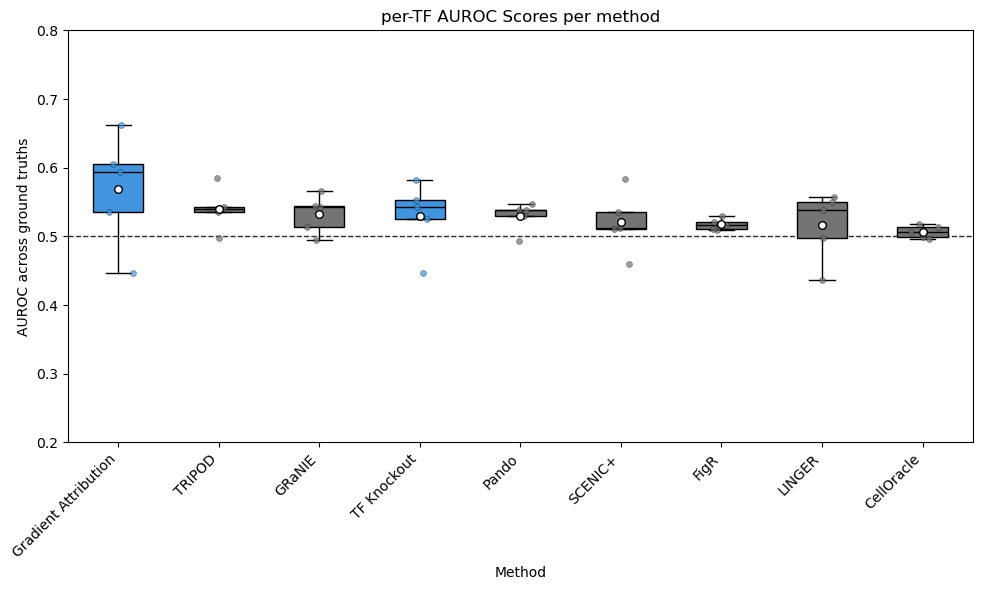

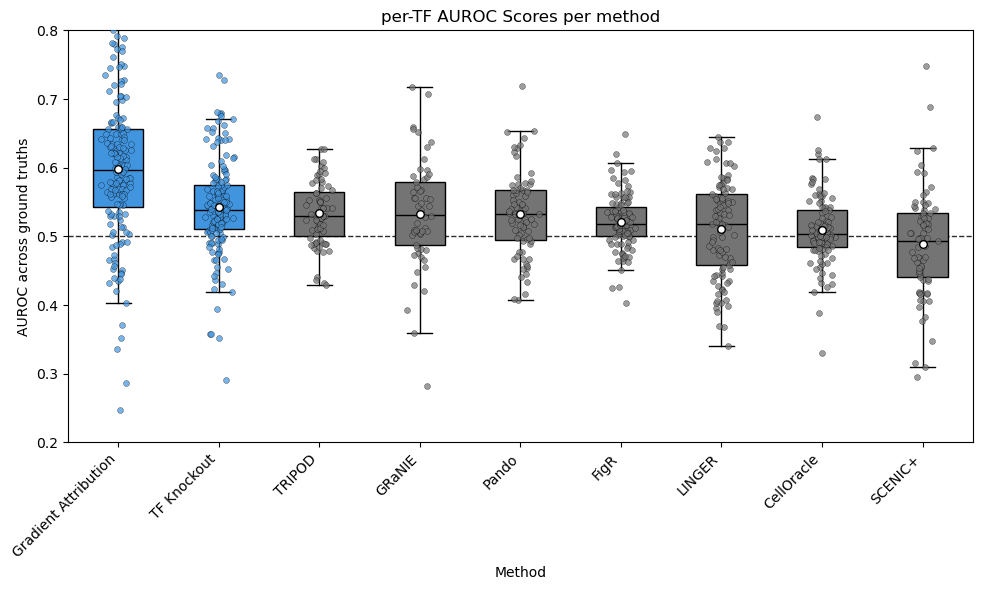

In [79]:
results_df = pd.DataFrame(all_results)
results_df.groupby("method")["auroc"].mean().sort_values(ascending=False)
results_df["name"] = results_df["method"]
plot_all_results_auroc_boxplot(results_df, per_tf=False)
plt.show()

df = per_tf_all_df.copy()

per_tf_mean_across_gt = (
    df
    .dropna(subset=["auroc"])
    .groupby(["method", "gt"], as_index=False)
    .agg(
        auroc=("auroc", "mean"),
        n_gt=("gt", "nunique"),
    )
)

# ===== Method 3: Calculate the Mean TF AUROC/AUPRC Across All GTs =====
per_tf_grouped = (
    df.dropna(subset=["auroc"])
    .groupby(['method', 'tf'], as_index=False)
    .agg(
        auroc=('auroc', 'mean'),
        n_gt=('gt', 'nunique'),
    )
)
per_tf_grouped["name"] = per_tf_grouped["method"]
per_tf_mean_across_gt["name"] = per_tf_mean_across_gt["method"]


#Plot the boxplots and save data like above methods
per_tf_mean_auroc_boxplot = plot_all_results_auroc_boxplot(per_tf_mean_across_gt, per_tf=True)

fig_per_tf = plot_all_results_auroc_boxplot(
    per_tf_grouped,
    per_tf=True
)
plt.show()


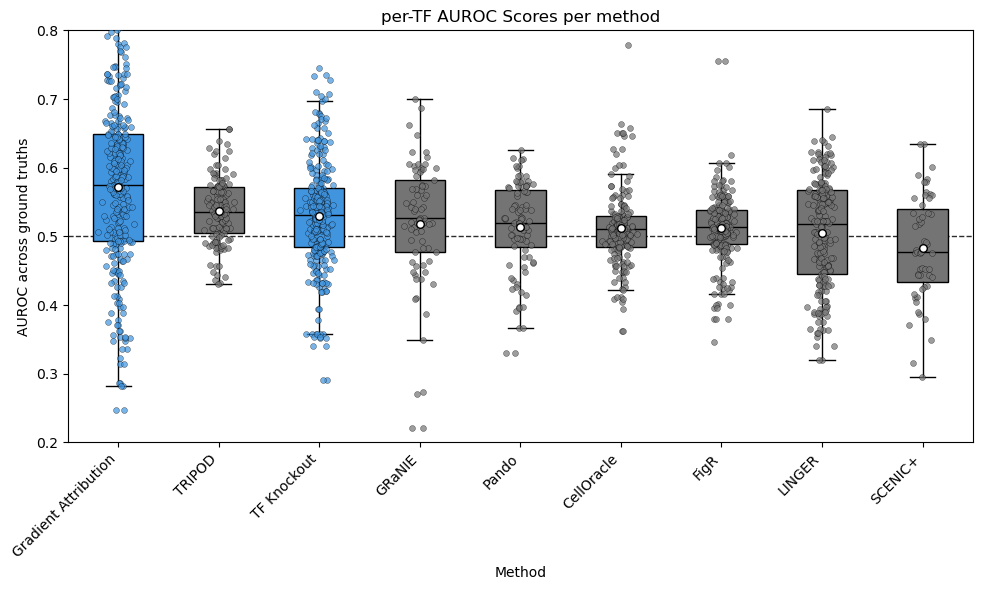

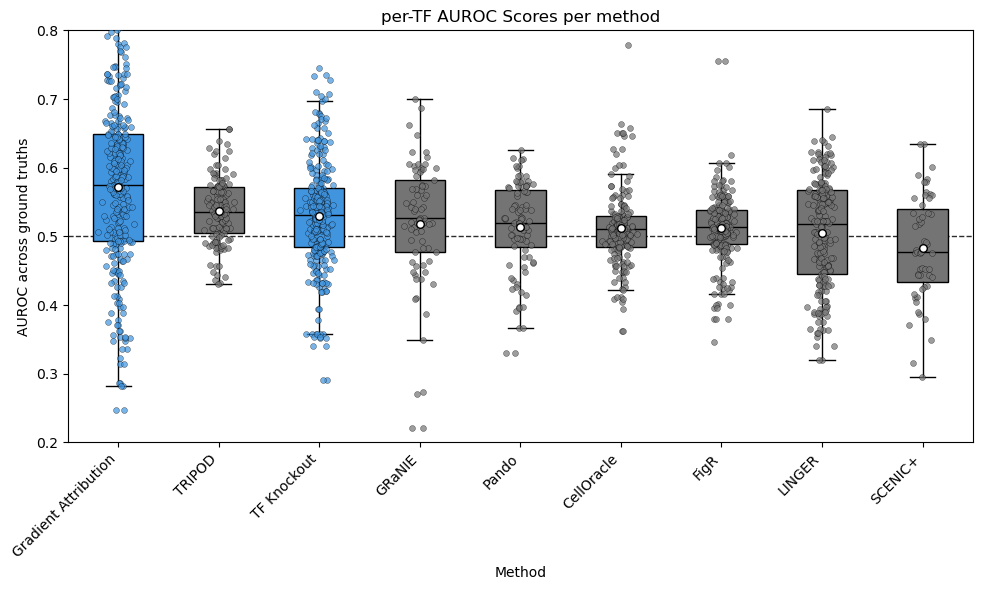

In [91]:
auroc_testing_plot_df = auroc_testing_per_tf_df.copy()
auroc_testing_plot_df["name"] = auroc_testing_plot_df["method"]
plot_all_results_auroc_boxplot(auroc_testing_plot_df, per_tf=True)